***
    
Demo Tensorflow for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-02-24
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving convection-diffusion equation (1D linear convection)
    
    2. Optimize PINN using CMA-ES on the Tensorflow framework
       -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022).

Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pylab as plt 
from matplotlib import cm

import os
import math
import numpy as np
import pandas as pd
import cma
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint, Callback
import tensorflow.keras.backend as K

from IPython.display import clear_output
from time import time, gmtime, strftime, localtime

import warnings
warnings.filterwarnings("ignore")

2022-12-13 21:53:42.341629: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from scipy import dot, exp, log, sqrt, floor, ones, randn, zeros_like, Inf, argmax, argmin, eye, outer, zeros
from scipy import array, power, diag, cos, sin, pi
from scipy.linalg import expm, cholesky, solve, norm, eig
from scipy.stats import multivariate_normal

import seaborn as sns

## run on CPU...
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# disable eager excution
tf.compat.v1.disable_eager_execution()

### 1. PINN for convection-diffusion equation

      
**Prior**

    1. Convection-Diffusion Equation: toy problem for a one-dimensional steady-state case 
        - v*u_x = k*u_xx
    2. BC 
        - u = 0, x = 0
        - u = 1, x = L
    3. General solution
        - u(x) = C1 + D1 exp(ux/k)
    4. Given BCs specified in 2, the solution become
        - u(x) = [1 - exp(Pe x/L)] / [1 - exp(Pe)]
        - Pe = uL/k
        

#### 1.0. Data

In [3]:
# function to generate analytical solution
def eval_u(x, Pe, L):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    u = (1. - tf.math.exp(Pe*x/L)) / (1. - tf.math.exp(Pe))
    return u.eval(session=tf.compat.v1.Session()) 

def eval_Pe(u, k, L):
    return u*L/k

#### 1.1. Geometry, PDE parameter & BC

In [4]:
# choose v (PDE parameter)
v = 6.

# fixed PDE & BC parameters k & L
k = 1.
L = 1.
Pe = eval_Pe(v, k, L)

# domain boundary
x_l, x_u = 0, L

#### 1.2. Sampling plan

2022-12-13 21:53:46.934119: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-12-13 21:53:46.987869: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-13 21:53:46.987931: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ihpcgs-02
2022-12-13 21:53:46.987946: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ihpcgs-02
2022-12-13 21:53:46.988163: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-12-13 21:53:46.988220: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-12-13 21:53:46.988232: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-12-13 21:53:46.989199: I tensorflow/core/platform/cpu_fe

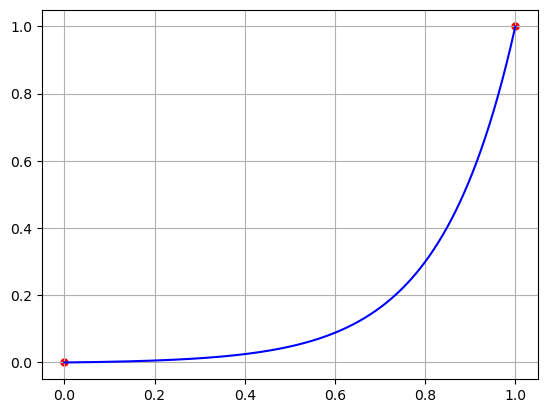

In [5]:
# grid points for evaluation
n_x = 10000
X_eval = np.linspace(x_l, x_u, n_x).reshape(-1, 1)
y_eval = eval_u(X_eval, Pe, L)

# BC sample
bc = np.where((X_eval == x_l) | (X_eval == x_u))[0]
X_bc, y_bc = X_eval[bc], y_eval[bc]

# visualize
plt.plot(X_eval, y_eval, c='blue'); plt.grid();
plt.scatter(X_bc, y_bc, c='red', s=25, marker='o');

#### 1.3. PDE-NN

In [6]:
# specify FF-PINN
def create_nn(n_nodes):

    # input layers -> x
    x = layers.Input(shape=(1,))
    
    # initializer  
    #initializer = tf.keras.initializers.HeUniform()  # hidden layers initializer
    initializer = tf.keras.initializers.GlorotUniform()  # hidden layers initializer
    
    # hidden layers
    hidden_s = layers.Dense(n_nodes, activation='tanh', kernel_initializer=initializer)(x)
    hidden_s = layers.Dense(n_nodes, activation='tanh', kernel_initializer=initializer)(hidden_s)
    hidden_s = layers.Dense(n_nodes, activation='tanh', kernel_initializer=initializer)(hidden_s)
    # output layers
    u = layers.Dense(1, use_bias=False, name="u")(hidden_s)

    # initiate model
    nn = models.Model(inputs=x, outputs=u)    
    
    # axillary PDE outputs
    u_x = K.gradients(u, x)[0]
    u_xx = K.gradients(u_x, x)[0]
    
    # PDE (physics laws): v*u_x = k*u_xx   
    pde = v*u_x - k*u_xx 
    pde_mse = tf.compat.v1.losses.mean_squared_error(labels=tf.zeros_like(pde), predictions=pde)
    
    # BCs (which define the problem)
    t_u = tf_bc(x)  # ground truth
    _bc = ( tf.equal(x, x_l) | tf.equal(x, x_u) )
    bc_mse = tf.compat.v1.losses.mean_squared_error(labels=tf.boolean_mask(t_u, _bc), predictions=tf.boolean_mask(u, _bc))    
  
    # u mse (for validation)
    u_mse = tf.compat.v1.losses.mean_squared_error(labels=t_u, predictions=u)

    # optimizer
    optimizer = tf.keras.optimizers.Adam(0.005)

    # compile model with [?] loss
    nn.compile(loss = compute_physic_loss(pde_mse, bc_mse),   
               optimizer = optimizer,
               metrics = [compute_pde_loss(pde_mse), compute_bc_loss(bc_mse), compute_u_loss(u_mse)])      

    # pathway to NN inside variables
    insiders = [u, pde, pde_mse, bc_mse, u_mse]
    eval_ins = K.function([nn.input, K.learning_phase()], insiders)   # evaluation function   
    
    return (nn, eval_ins)


# f: IC/BC
def tf_bc(x):
    u = (1. - tf.math.exp(Pe*x/L)) / (1. - tf.math.exp(Pe))
    return u

In [7]:
# define loss function (Physics: PDE + BC loss)
def compute_physic_loss(pde_mse, bc_mse):
    def physic_loss(y_true, y_pred): return (pde_mse + bc_mse)
    return physic_loss

# define loss function (BC loss)
def compute_bc_loss(bc_mse):
    def bc_loss(y_true, y_pred): return bc_mse
    return bc_loss # return a function 

# define loss function (PDE loss)
def compute_pde_loss(pde_mse):
    def pde_loss(y_true, y_pred): return pde_mse
    return pde_loss # return a function

# define loss function (u loss)
def compute_u_loss(u_mse):
    def u_loss(y_true, y_pred): return u_mse
    return u_loss # return a function

### 3. Optimize PINN with [Neuroevolution / xNES]

In [8]:
# initiate NN model (& pathway to internal values)
n_nodes = 10
nn, eval_ins = create_nn(n_nodes)

# initial weights
w0 = np.array([])
nn_weights = nn.get_weights()
for _g in nn_weights: w0 = np.append(w0, _g.flatten())

nn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 10)                20        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
u (Dense)                    (None, 1)                 10        
Total params: 250
Trainable params: 250
Non-trainable params: 0
_________________________________________________________________


In [9]:
# nn weights structure 
nn_weights = nn.get_weights()
nn_wlen = len(nn_weights)
nn_wshape = [_w.shape for _w in nn_weights]
nn_widx = np.cumsum([len(_w.flatten()) for _w in nn_weights])
nn_nweights = nn_widx[-1]

In [10]:
# function to evaluate fitness given the weights
def nn_fitness(_weights):
    _weights = np.split(_weights, nn_widx[:-1])
    _weights = [_weights[i].reshape(nn_wshape[i]) for i in range(nn_wlen)]
    nn.set_weights(_weights)
    _x = X_eval
    _, _, pde_mse, bc_mse, _ = eval_ins(_x)
    fitness = (pde_mse + bc_mse)
    return fitness

In [11]:
x, es = cma.fmin2(nn_fitness, w0, 5e-2, options={'ftarget':1e-5, 'popsize':80, 'maxiter':500, 'verb_disp':1})

(40_w,80)-aCMA-ES (mu_w=21.8,w_1=9%) in dimension 250 (seed=1042318, Tue Dec 13 21:53:47 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     80 3.885397613048553e-01 1.0e+00 4.77e-02  5e-02  5e-02 0:00.6
    2    160 3.959518074989319e-01 1.0e+00 4.59e-02  5e-02  5e-02 0:01.0
    3    240 3.159151673316956e-01 1.0e+00 4.46e-02  4e-02  4e-02 0:01.4
    4    320 3.124673962593079e-01 1.0e+00 4.36e-02  4e-02  4e-02 0:01.8
    5    400 3.111330270767212e-01 1.0e+00 4.28e-02  4e-02  4e-02 0:02.2
    6    480 2.864958345890045e-01 1.0e+00 4.22e-02  4e-02  4e-02 0:02.6
    7    560 2.680452764034271e-01 1.0e+00 4.17e-02  4e-02  4e-02 0:03.0
    8    640 2.823452949523926e-01 1.0e+00 4.15e-02  4e-02  4e-02 0:03.4
    9    720 2.723072767257690e-01 1.0e+00 4.15e-02  4e-02  4e-02 0:03.8
   10    800 2.702654302120209e-01 1.0e+00 4.14e-02  4e-02  4e-02 0:04.2
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
   11    880 2.620238363742828e

  102   8160 2.479059696197510e-01 1.3e+00 3.93e-02  4e-02  4e-02 0:40.7
  103   8240 2.478951662778854e-01 1.3e+00 3.94e-02  4e-02  4e-02 0:41.1
  104   8320 2.483955770730972e-01 1.3e+00 3.95e-02  4e-02  4e-02 0:41.5
  105   8400 2.477214783430099e-01 1.3e+00 3.96e-02  4e-02  4e-02 0:41.9
  106   8480 2.478787153959274e-01 1.3e+00 3.98e-02  4e-02  4e-02 0:42.3
  107   8560 2.480788826942444e-01 1.3e+00 3.98e-02  4e-02  4e-02 0:42.7
  108   8640 2.487779855728149e-01 1.3e+00 3.98e-02  4e-02  4e-02 0:43.1
  109   8720 2.487329244613647e-01 1.3e+00 3.98e-02  4e-02  4e-02 0:43.4
  110   8800 2.479341775178909e-01 1.3e+00 3.97e-02  4e-02  4e-02 0:43.8
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  111   8880 2.479437589645386e-01 1.3e+00 3.96e-02  4e-02  4e-02 0:44.2
  112   8960 2.479950636625290e-01 1.3e+00 3.95e-02  4e-02  4e-02 0:44.6
  113   9040 2.482535243034363e-01 1.3e+00 3.94e-02  4e-02  4e-02 0:45.0
  114   9120 2.483030706644058e-01 1.3e+00 3.93e-02 

  205  16400 2.481266856193542e-01 1.5e+00 3.19e-02  3e-02  3e-02 1:21.2
  206  16480 2.478368729352951e-01 1.5e+00 3.16e-02  3e-02  3e-02 1:21.6
  207  16560 2.478833049535751e-01 1.5e+00 3.15e-02  3e-02  3e-02 1:22.0
  208  16640 2.479490935802460e-01 1.5e+00 3.14e-02  3e-02  3e-02 1:22.4
  209  16720 2.479638159275055e-01 1.5e+00 3.12e-02  3e-02  3e-02 1:22.8
  210  16800 2.482081502676010e-01 1.5e+00 3.12e-02  3e-02  3e-02 1:23.2
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  211  16880 2.482088953256607e-01 1.5e+00 3.11e-02  3e-02  3e-02 1:23.6
  212  16960 2.478092759847641e-01 1.5e+00 3.09e-02  3e-02  3e-02 1:24.0
  213  17040 2.477276623249054e-01 1.5e+00 3.07e-02  3e-02  3e-02 1:24.4
  214  17120 2.477081120014191e-01 1.5e+00 3.05e-02  3e-02  3e-02 1:24.8
  215  17200 2.476940006017685e-01 1.5e+00 3.02e-02  3e-02  3e-02 1:25.1
  216  17280 2.476644515991211e-01 1.5e+00 3.01e-02  3e-02  3e-02 1:25.5
  217  17360 2.476444244384766e-01 1.5e+00 3.00e-02 

  308  24640 2.478408962488174e-01 1.6e+00 3.49e-02  3e-02  4e-02 2:02.1
  309  24720 2.477228045463562e-01 1.6e+00 3.50e-02  3e-02  4e-02 2:02.5
  310  24800 2.480135113000870e-01 1.6e+00 3.50e-02  3e-02  4e-02 2:02.9
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  311  24880 2.479533106088638e-01 1.6e+00 3.49e-02  3e-02  4e-02 2:03.3
  312  24960 2.478008717298508e-01 1.6e+00 3.49e-02  3e-02  4e-02 2:03.7
  313  25040 2.477287203073502e-01 1.6e+00 3.48e-02  3e-02  4e-02 2:04.1
  314  25120 2.477231174707413e-01 1.6e+00 3.47e-02  3e-02  4e-02 2:04.5
  315  25200 2.477816790342331e-01 1.6e+00 3.46e-02  3e-02  4e-02 2:04.8
  316  25280 2.480923831462860e-01 1.6e+00 3.46e-02  3e-02  4e-02 2:05.2
  317  25360 2.478060424327850e-01 1.6e+00 3.47e-02  3e-02  4e-02 2:05.6
  318  25440 2.478817999362946e-01 1.6e+00 3.48e-02  3e-02  4e-02 2:06.0
  319  25520 2.477712780237198e-01 1.6e+00 3.47e-02  3e-02  4e-02 2:06.4
  320  25600 2.477856874465942e-01 1.6e+00 3.48e-02 

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  411  32880 2.477080971002579e-01 1.7e+00 3.00e-02  3e-02  3e-02 2:42.5
  412  32960 2.477811723947525e-01 1.7e+00 3.00e-02  3e-02  3e-02 2:43.0
  413  33040 2.476686239242554e-01 1.7e+00 3.00e-02  3e-02  3e-02 2:43.4
  414  33120 2.478191256523132e-01 1.7e+00 2.99e-02  3e-02  3e-02 2:43.8
  415  33200 2.477600127458572e-01 1.7e+00 2.99e-02  3e-02  3e-02 2:44.2
  416  33280 2.477509528398514e-01 1.7e+00 2.99e-02  3e-02  3e-02 2:44.6
  417  33360 2.478846758604050e-01 1.7e+00 2.98e-02  3e-02  3e-02 2:45.0
  418  33440 2.478756606578827e-01 1.7e+00 2.97e-02  3e-02  3e-02 2:45.4
  419  33520 2.477064728736877e-01 1.7e+00 2.95e-02  3e-02  3e-02 2:45.8
  420  33600 2.477283477783203e-01 1.7e+00 2.93e-02  3e-02  3e-02 2:46.2
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
  421  33680 2.477031797170639e-01 1.7e+00 2.92e-02  3e-02  3e-02 2:46.6
  422  33760 2.476382404565811e-01 1.7e+00 2.91e-02  